In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold
import tqdm
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
import pickle
#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
p231, p222_1, p222_2, p222_3, p229 = modules.build_patients()
pat_list = [p231, p222_1, p222_2, p222_3]
for pat in pat_list:
    JJ.save_object(pat, '../patients/' + pat.id +'.p')

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [3]:
col_rs = hp.col_rs
col_es = hp.col_es
col_le = hp.col_le

p231, p222_1, p222_2, p222_3 = pickle.load(open(hp.prepath_pat + "231.p", "rb" )),pickle.load(open(hp.prepath_pat + "222_1.p", "rb" )), pickle.load(open(hp.prepath_pat + "222_2.p", "rb" )), pickle.load(open(hp.prepath_pat + "222_3.p", "rb" ))


In [7]:
p222_1.features

,filename,region_start_time,sleep,delta1,delta2,delta3,delta4,theta1,theta2,theta3,...,all1,all2,all3,all4,i12,i34,epoch,label,id,if_stimulated
521,1.309980e+17,2016-02-12 03:59:55.968000,1.0,65.436218,364.151777,63.215202,202.719760,101.081960,344.757574,133.174825,...,393.474657,1179.278104,502.973709,872.480713,0.0,0.0,0,True,222_1,False
522,1.309980e+17,2016-02-12 15:59:53.030400,0.0,66.952992,206.077023,34.415236,91.723497,102.638616,395.431395,87.026204,...,288.098271,1034.826536,407.075884,805.376122,1.0,0.0,0,True,222_1,False
523,1.309989e+17,2016-02-12 20:59:51.964800,0.0,39.293362,244.848856,34.561427,66.295568,63.117262,448.411932,85.858412,...,214.307536,995.629253,477.849916,709.906735,0.0,0.0,0,True,222_1,False
524,1.309989e+17,2016-02-13 03:59:41.020800,1.0,37.736205,121.930635,23.548927,73.607882,58.570117,291.327793,73.162509,...,199.280474,765.134289,423.093376,693.146568,0.0,0.0,0,True,222_1,False
525,1.309989e+17,2016-02-13 15:59:39.033600,0.0,48.837088,159.177819,29.398845,97.541387,87.276202,475.231517,75.751883,...,256.451487,1035.538565,379.213366,822.637315,0.0,0.0,0,True,222_1,False
526,1.309997e+17,2016-02-13 20:59:37.968000,0.0,41.313928,132.279432,17.281833,74.976220,68.591295,388.279137,68.100650,...,225.398151,858.877318,416.540262,790.444117,0.0,1.0,0,True,222_1,False
527,1.309997e+17,2016-02-14 03:59:36.960000,1.0,61.166778,273.677298,33.567358,81.248635,67.960011,407.512272,63.612451,...,246.179542,1191.769707,405.645495,690.393928,0.0,0.0,0,True,222_1,False
528,1.309997e+17,2016-02-14 15:59:34.022400,0.0,56.434457,146.502404,26.545324,113.718263,92.329255,422.707738,83.928926,...,263.857999,988.330991,427.060643,896.721623,1.0,1.0,0,True,222_1,False
529,1.310006e+17,2016-02-14 20:59:33.993600,0.0,78.334224,375.483229,49.405315,121.113454,92.537941,457.397495,93.631180,...,364.616993,1360.944809,473.557109,802.123650,0.0,0.0,0,True,222_1,False
530,1.310006e+17,2016-02-15 03:59:22.963200,1.0,50.442024,143.936747,40.430945,101.728189,40.123491,232.779533,87.369548,...,193.653876,776.878225,372.658872,673.987872,0.0,0.0,0,True,222_1,False


In [4]:
def parameter_tuning(pat, X_train, X_test, y_train, y_test, classifier, C_range_num = 30, if_save = 0,
                     nfold = 10, if_show = 1):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    

    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-2, 1, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-3, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        pat.estimator[classifier] = clf_try
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 600
        mss_list = [20,25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [12,13,14,15,16]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 2000
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [1,2,3], [0.1,0.15,0.2, 0.3, 0.4], [0.02, 0.01,0.005], [10,20,30] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score for validations set: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    if if_show:
        JJ.show_result(y_pred, y_test, df, clf_name, if_save = if_save)
    
    if if_save:
        pat.result[classifier] = df
        pat.estimator[classifier] = clf_best
        pat.score[classifier] = clf_grid.best_score_
        pat.params[classifier] = clf_grid.best_params_



Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 30.6min finished


Best score for validations set: 0.850188137270412
Best parameters: {'max_depth': 3, 'learning_rate': 0.005, 'min_samples_leaf': 30, 'subsample': 0.4}
Confusion matrix, without normalization


,params,mean_test_score
134,"{'max_depth': 3, 'learning_rate': 0.005, 'min_samples_leaf': 30, 'subsample': 0.4}",0.850188
113,"{'max_depth': 2, 'learning_rate': 0.005, 'min_samples_leaf': 20, 'subsample': 0.3}",0.849860
118,"{'max_depth': 2, 'learning_rate': 0.005, 'min_samples_leaf': 30, 'subsample': 0.3}",0.849457
119,"{'max_depth': 2, 'learning_rate': 0.005, 'min_samples_leaf': 30, 'subsample': 0.4}",0.848894
59,"{'max_depth': 1, 'learning_rate': 0.01, 'min_samples_leaf': 30, 'subsample': 0.4}",0.848731
58,"{'max_depth': 1, 'learning_rate': 0.01, 'min_samples_leaf': 30, 'subsample': 0.3}",0.848631
82,"{'max_depth': 3, 'learning_rate': 0.01, 'min_samples_leaf': 20, 'subsample': 0.2}",0.847872
74,"{'max_depth': 2, 'learning_rate': 0.01, 'min_samples_leaf': 30, 'subsample': 0.4}",0.847684
88,"{'max_depth': 3, 'learning_rate': 0.01, 'min_samples_leaf': 30, 'subsample': 0.3}",0.847291
133,"{'max_depth': 3, 'learning_rate': 0.005, 'min_samples_leaf': 30, 'subsample': 0.3}",0.846632


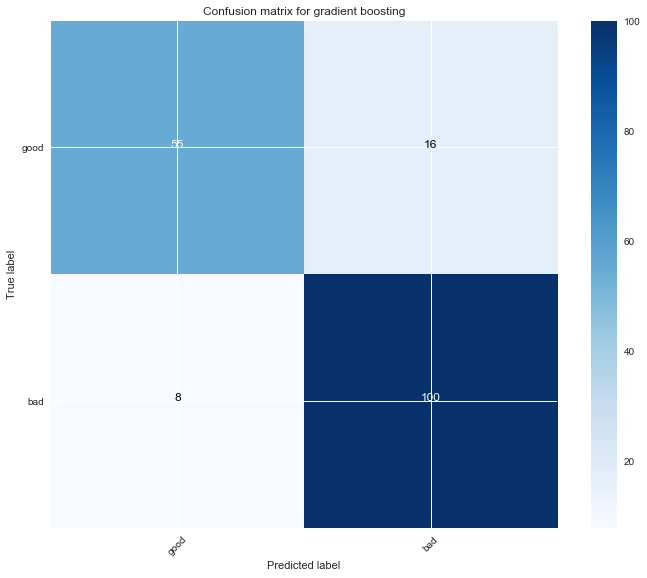

In [6]:
X_train, X_test, y_train, y_test = modules.get_ml_data(p222_1, if_remove_icd = 0, if_remove_sleep=1)
parameter_tuning(p222_1,X_train, X_test, y_train, y_test,7, C_range_num = 100, 
                     nfold = 10, if_save = 0, if_show = 1)

In [18]:
p222_1.features

,filename,region_start_time,sleep,delta1,delta2,delta3,delta4,theta1,theta2,theta3,...,all1,all2,all3,all4,i12,i34,epoch,label,id,if_stimulated
521,1.309980e+17,2016-02-12 03:59:55.968000,1.0,65.436218,364.151777,63.215202,202.719760,101.081960,344.757574,133.174825,...,393.474657,1179.278104,502.973709,872.480713,0.0,0.0,0,True,222_1,False
522,1.309980e+17,2016-02-12 15:59:53.030400,0.0,66.952992,206.077023,34.415236,91.723497,102.638616,395.431395,87.026204,...,288.098271,1034.826536,407.075884,805.376122,1.0,0.0,0,True,222_1,False
523,1.309989e+17,2016-02-12 20:59:51.964800,0.0,39.293362,244.848856,34.561427,66.295568,63.117262,448.411932,85.858412,...,214.307536,995.629253,477.849916,709.906735,0.0,0.0,0,True,222_1,False
524,1.309989e+17,2016-02-13 03:59:41.020800,1.0,37.736205,121.930635,23.548927,73.607882,58.570117,291.327793,73.162509,...,199.280474,765.134289,423.093376,693.146568,0.0,0.0,0,True,222_1,False
525,1.309989e+17,2016-02-13 15:59:39.033600,0.0,48.837088,159.177819,29.398845,97.541387,87.276202,475.231517,75.751883,...,256.451487,1035.538565,379.213366,822.637315,0.0,0.0,0,True,222_1,False
526,1.309997e+17,2016-02-13 20:59:37.968000,0.0,41.313928,132.279432,17.281833,74.976220,68.591295,388.279137,68.100650,...,225.398151,858.877318,416.540262,790.444117,0.0,1.0,0,True,222_1,False
527,1.309997e+17,2016-02-14 03:59:36.960000,1.0,61.166778,273.677298,33.567358,81.248635,67.960011,407.512272,63.612451,...,246.179542,1191.769707,405.645495,690.393928,0.0,0.0,0,True,222_1,False
528,1.309997e+17,2016-02-14 15:59:34.022400,0.0,56.434457,146.502404,26.545324,113.718263,92.329255,422.707738,83.928926,...,263.857999,988.330991,427.060643,896.721623,1.0,1.0,0,True,222_1,False
529,1.310006e+17,2016-02-14 20:59:33.993600,0.0,78.334224,375.483229,49.405315,121.113454,92.537941,457.397495,93.631180,...,364.616993,1360.944809,473.557109,802.123650,0.0,0.0,0,True,222_1,False
530,1.310006e+17,2016-02-15 03:59:22.963200,1.0,50.442024,143.936747,40.430945,101.728189,40.123491,232.779533,87.369548,...,193.653876,776.878225,372.658872,673.987872,0.0,0.0,0,True,222_1,False


In [19]:
def parameter_tuning_sleep(pat, C_range_num, if_scaler = 1, if_remove_icd = 1, if_remove_sleep=1, sleep_class = None, if_save = 1, if_show = 0):
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_scaler = if_scaler, if_remove_icd = if_remove_icd, if_remove_sleep = if_remove_sleep, sleep_class = sleep_class)
    for classifier_int in tqdm.trange(1,hp.num_classifier + 1):
        parameter_tuning(pat, X_train, X_test, y_train, y_test, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)
    if if_save:
        JJ.save_object(pat, hp.prepath_pat + pat.id +'_trained.p')

In [20]:
parameter_tuning_sleep(p222_1, C_range_num = 100, if_remove_sleep = 1,sleep_class =None, if_save = 1)


  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.6s finished

 14%|█▍        | 1/7 [00:11<01:09, 11.56s/it]

Best score for validations set: 0.6607538225646696
Best parameters: {'C': 0.1858878725433549, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   26.6s finished

 29%|██▊       | 2/7 [00:38<01:35, 19.10s/it]

Best score for validations set: 0.6866631208854427
Best parameters: {'C': 5.005967430237205, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.5s finished

 71%|███████▏  | 5/7 [00:41<00:16,  8.34s/it]

Best score for validations set: 0.6222094257168216
Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 5}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.1min finished

 86%|████████▌ | 6/7 [05:50<00:58, 58.37s/it]

Best score for validations set: 0.667040573640753
Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 20, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 26.6min finished

100%|██████████| 7/7 [32:26<00:00, 278.12s/it]


Best score for validations set: 0.6534838697546004
Best parameters: {'max_depth': 1, 'learning_rate': 0.02, 'min_samples_leaf': 30, 'subsample': 0.2}


In [9]:
def parameter_tuning_all(pat, C_range_num, if_scaler = 1, if_remove_icd = 1, if_remove_sleep=1, if_save = 1, if_show = 0):
    X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_scaler = if_scaler, if_remove_icd = if_remove_icd, if_remove_sleep = if_remove_sleep)
    for classifier_int in tqdm.trange(1,hp.num_classifier + 1):
        parameter_tuning(pat, X_train, X_test, y_train, y_test, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)
    if if_save:
        JJ.save_object(pat, hp.prepath_pat + pat.id +'_trained_sleep.p')

In [10]:
parameter_tuning_all(p222_1, C_range_num = 100, if_scaler = hp.if_scaler, 
                     if_remove_icd = hp.if_remove_icd, if_remove_sleep = 1, if_save = 1)

  0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   12.3s finished
 14%|█▍        | 1/7 [00:12<01:13, 12.31s/it]

Best score for validations set: 0.6601387357774628
Best parameters: {'C': 0.18151583967130078, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   26.3s finished
 57%|█████▋    | 4/7 [00:38<00:29,  9.71s/it]

Best score for validations set: 0.6865372921513665
Best parameters: {'C': 5.207792123899966, 'gamma': 0.03571428571428571, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.4s finished
 71%|███████▏  | 5/7 [00:42<00:16,  8.45s/it]

Best score for validations set: 0.6314990319360557
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 10}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.0min finished
 86%|████████▌ | 6/7 [05:45<00:57, 57.62s/it]

Best score for validations set: 0.6695946333440731
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 25, 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 26.5min finished
100%|██████████| 7/7 [32:16<00:00, 276.71s/it]

Best score for validations set: 0.6561958743715802
Best parameters: {'max_depth': 2, 'learning_rate': 0.01, 'min_samples_leaf': 20, 'subsample': 0.15}


In [23]:
JJ.ensemble_model(X_train, y_train, X_test, y_test, p231, if_save = 0)

0.8603351955307262


/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [7]:
parameter_tuning_all(p222_1, C_range_num = 100, if_scaler = hp.if_scaler, if_remove_icd = hp.if_remove_icd, if_save = 1)

  0%|          | 0/7 [00:00<?, ?it/s]

Total outliers removed: 19
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.9s finished
 14%|█▍        | 1/7 [00:11<01:11, 11.96s/it]

Best score for validations set: 0.6607585081923943
Best parameters: {'C': 0.19517445578083695, 'penalty': 'l1'}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   27.6s finished
 29%|██▊       | 2/7 [00:39<01:38, 19.80s/it]

Best score for validations set: 0.6867889496195189
Best parameters: {'C': 4.90241546749882, 'kernel': 'rbf', 'gamma': 0.03571428571428571}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.6s finished
 71%|███████▏  | 5/7 [00:43<00:17,  8.65s/it]

Best score for validations set: 0.6311262313615518
Best parameters: {'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': 8}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.1min finished
 86%|████████▌ | 6/7 [05:50<00:58, 58.35s/it]

Best score for validations set: 0.6664817143862415
Best parameters: {'max_features': 'auto', 'min_samples_split': 30, 'criterion': 'entropy', 'max_depth': 16}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 61.2min finished
100%|██████████| 7/7 [1:07:02<00:00, 574.67s/it]

Best score for validations set: 0.6507336969013348
Best parameters: {'learning_rate': 0.005, 'min_samples_leaf': 20, 'subsample': 0.2, 'max_depth': 1}
